## Building Hidden Markov Models (*HMMs*) for speech recognition

We'll use *Gaussian HMMs* to model our data. *HMMs* are great tool for modeling time series data. As an audio signa is a time series signal, so the *HMMs* fit our needs. 

*HMMs* are popular because they can be trained automatically and are simple and computationally feasible to use. A *HMM* represent probability distrubutions over sequencs of observations.

In this document we use **hmmlearn** package built with Sphinx and **python_speech features** built for MFCC.

We need train data to build our speech recognizer. We will use the database available at [here](https://code.google.com/archive/p/hmm-speech-recognition/downloads). This data set contains seven different words, where each word has 15 audio files associated with it. We'll build an *HMM* model for each class by training our model on given dataset. Then after build model, given new input file, we need to run all the models on this file and pick the one with the best score.

In [1]:
import numpy as np
import os
from scipy.io import wavfile 
from hmmlearn import hmm
from python_speech_features import mfcc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

from utils import *

In [2]:
fpaths = []
labels = []
word_spoken = []


dataset = 'audio'
input_folder = 'data\{}'.format(dataset)

# pars the input directory that contains audio files
# get audio files and their lables

for f in os.listdir(input_folder):
    for w in os.listdir(input_folder+'\\'+ f):
        fpaths.append(input_folder+'\\'+f+'\\'+w)
        labels.append(f)
        if f not in word_spoken:
            word_spoken.append(f)
print("Spoken words: "+ str(word_spoken))

Dataset words: ['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple']


## Extracting frequeny domain features

At the second stage we convet a signal into the freqency domain. In monst modern speech recognitoon freqeency-domain features are used as key component. In case of multispeakers MFFC feature extraction works best. After convert a signal into a freq domain, it's requered to convert it into a useable form. **Mel Frequency Cepstral Coefficients (MFCC)** is a good way to do that. *MFCC* takes the power spectrum of a signal and then uses a combination of filter banks and disrete cosinetransform to extract pattern of phones or features.

After extracting **MFFC** features we exract data into single data matrix, and a label vector with the correct label for eac data file is ceated. 

In [3]:
#Files can be heard in Linux using the following commands from the command line
#cat kiwi07.wav | aplay -f S16_LE -t wav -r 8000
#Files are signed 16 bit raw, sample rate 8000
from scipy.io import wavfile

data = []
for n,file in enumerate(fpaths):
    sampling_freq, audio = wavfile.read(file)
    # Extract MFCC features
    mfcc_features = mfcc(audio, sampling_freq)
    data.insert(n,mfcc_features)

In [4]:
#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', len(data))
all_labels = np.zeros(len(data))
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Labels and label indices', all_labels)

Number of files total: 105
Labels and label indices [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


## MHH Trainer Class

In [5]:
# class to handle HMM processing
class HMMTrainer(object):  
    '''
    Parameters
    ----------
    
    n_components: parameter defines the number of hidden states
    cov_type: defines the type of covariance in transition matrix
    n_iter: indicates the number of iterations for traning
    
    Choice of parameters depends on the data. 
    '''
    def __init__(self, model_name='GaussianHMM', n_components=3, covariance_type="diag",
                 init_params="cm", params="cmt", n_iter=1000):
        
        # initialize
        self.model_name = model_name
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.init_params = init_params
        self.params = params
        self.n_iter = n_iter
        self.models = []


        # define model
        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components,
                                         covariance_type=self.covariance_type,
                                         init_params=self.init_params, 
                                         params=self.params,
                                         n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')
            
            
    # train data is 2D aray, where each frow is k-dimensions
    def train(self, X):
        
        # ingonre divisin by 0
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X))
        
    # run the model on input data and get score
    def get_score(self, input_data):
        return self.model.score(input_data)


## Create train and test dataset

In [6]:
# convert list to array
data = np.array(data)

from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(all_labels, test_size=0.2, random_state=0)


for train_index, test_index in sss:
    X_train, X_test = data[train_index, ...], data[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (84,)
Size of testing matrix: (21,)


C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
hmm_models = [] # list to keep all models

unique_labels = set(all_labels)
for label in unique_labels:
    
    # get label datas
    tmp_label_data=X_train[y_train == label]
    
    # concate all label data
    train_label=np.array([])
    train_label=tmp_label_data[0]
    for i in range(1,tmp_label_data.shape[0]):
        train_label=np.append(train_label,tmp_label_data[i],axis=0)
    
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(train_label)
    hmm_models.append((hmm_trainer, label))
    hmm_trainer = None

C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Anar\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\A

In [8]:
logprob = np.array([[m[0].get_score(i) for i in X_test] for m in hmm_models])
predicted_label = np.argmax(logprob, axis=0)
error = (predicted_label != y_test)
print('Overall test accuracy: %.2f percent' % (100 * (1 - np.mean(error))))

Overall test accuracy: 100.00 percent


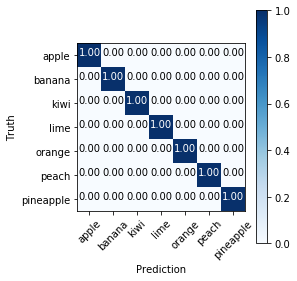

In [9]:
# plot confusion matrix
conf_mat = confusion_matrix(y_test, predicted_label)
plot_confusion_matrix(conf_mat, word_spoken, 'Prediction', 'Truth', normalize=True)